In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, RDKFingerprint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.functional import F
import torchbnn as bnn
import json
import warnings
warnings.filterwarnings('ignore')


# Load Data

In [ ]:
data = pd.read_csv('PATH_TO_TEST_DATA')
data.head()

,CXSMILES,Molecule Name,Set,pIC50 (SARS-CoV-2 Mpro)
0,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...,ASAP-0000175,Test,5.57
1,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...,ASAP-0000528,Test,7.44
2,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000541,Test,6.48
3,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...,ASAP-0000733,Test,7.87
4,CNC(=O)CN1C[C@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C[...,ASAP-0000738,Test,7.60


In [3]:
data.shape

(261, 4)

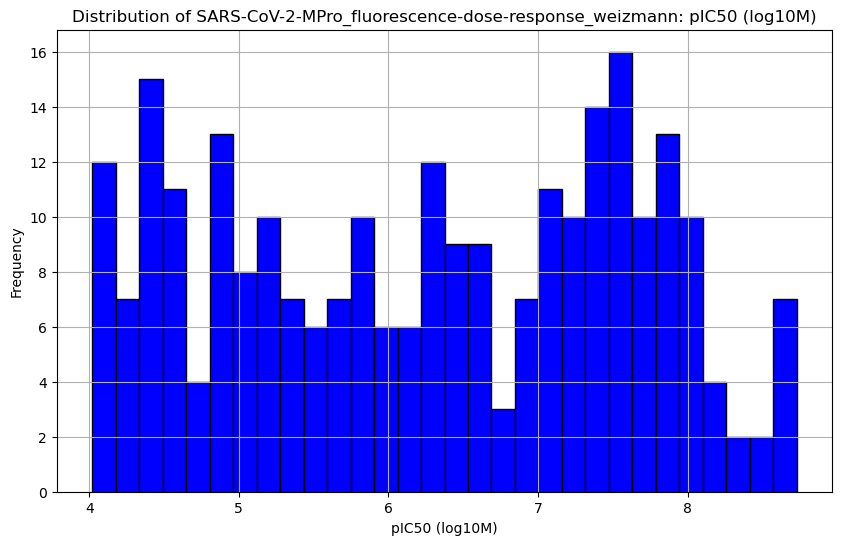

In [4]:
# Convert to numeric and drop NaN in one step
pIC50_data = pd.to_numeric(
    data['pIC50 (SARS-CoV-2 Mpro)'])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(pIC50_data, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M)')
plt.xlabel('pIC50 (log10M)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
data = data[['pIC50 (SARS-CoV-2 Mpro)', 'CXSMILES']]
data.head()


,pIC50 (SARS-CoV-2 Mpro),CXSMILES
0,5.57,C=CC(=O)NC1=CC=CC(N(CC2=CC=CC(Cl)=C2)C(=O)CC2=...
1,7.44,CNC(=O)CN1C[C@]2(CCN(C3=CN=CC4=CC=C(OC[C@H](O)...
2,6.48,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...
3,7.87,CNC(=O)CN1C[C@@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C...
4,7.60,CNC(=O)CN1C[C@]2(C(=O)N(C3=CN=CC4=CC=CC=C34)C[...


In [6]:
def generate_fingerprints(smiles, **kwargs):
    """
    Generate different types of molecular fingerprints
    
    Args:
        smiles: SMILES string
        fp_type: Type of fingerprint ('morgan', 'rdkit', 'morgan_rdkit')
        **kwargs: Additional parameters for fingerprint generation
    
    Returns:
        numpy array of fingerprint bits
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    if kwargs['fp_type'] == 'morgan':
        radius = kwargs.get('radius', 2)
        nBits = kwargs.get('nBits', 2048)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
        return np.array(fp)
    
    elif kwargs['fp_type'] == 'rdkit':
        maxPath = kwargs.get('maxPath', 7)
        nBits = kwargs.get('nBits', 2048)
        fp = RDKFingerprint(mol, maxPath=maxPath, fpSize=nBits)
        return np.array(fp)
    
    elif kwargs['fp_type'] == 'morgan_rdkit':
        # Combined Morgan + RDKit fingerprints
        morgan_radius = kwargs.get('morgan_radius', 2)
        morgan_nBits = kwargs.get('morgan_nBits', 1024)
        rdkit_maxPath = kwargs.get('rdkit_maxPath', 7)
        rdkit_nBits = kwargs.get('rdkit_nBits', 1024)
        
        morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=morgan_radius, nBits=morgan_nBits)
        rdkit_fp = RDKFingerprint(mol, maxPath=rdkit_maxPath, fpSize=rdkit_nBits)
        
        # Concatenate fingerprints
        combined_fp = np.concatenate([np.array(morgan_fp), np.array(rdkit_fp)])
        return combined_fp
    
    else:
        raise ValueError(f"Unknown fingerprint type: {kwargs['fp_type']}")
    
def prepare_data_with_fingerprints(data, fp_config):
    """
    Prepare data with specified fingerprint configuration
    
    Args:
        data: Pandas df with data containing 'CXSMILES' and 'pIC50'
        fp_config: Dictionary containing fingerprint configuration
    
    Returns:
        X, y arrays and input feature size
    """

    
    # Generate fingerprints based on configuration
    print(f"Generating {fp_config['fp_type']} fingerprints...")
    
    fingerprints = []
    valid_indices = []
    
    for idx, smiles in enumerate(data['CXSMILES']):
        if pd.notna(smiles):
            fp = generate_fingerprints(smiles, **fp_config)
            if fp is not None:
                fingerprints.append(fp)
                valid_indices.append(idx)
    
    if not fingerprints:
        raise ValueError("No valid fingerprints generated")
    
    # Filter data to valid molecules
    data = data.iloc[valid_indices].reset_index(drop=True)
    data['Fingerprint'] = fingerprints
    
    # Clean pIC50 data
    data.dropna(subset=['pIC50 (SARS-CoV-2 Mpro)'], inplace=True)
    data.dropna(subset=['pIC50 (SARS-CoV-2 Mpro)'], inplace=True)
    data['pIC50'] = data['pIC50 (SARS-CoV-2 Mpro)'].astype(float)
    
    X = np.array(list(data["Fingerprint"]))
    y = data["pIC50 (SARS-CoV-2 Mpro)"].values
    input_features = X.shape[1]
    
    print(f"Generated fingerprints with {input_features} features for {len(X)} molecules")
    
    return X, y, input_features

In [ ]:
with open('./SARS_potency_BNN_complete_config_final.json') as f:
    model_hyperparameters = json.load(f)
print(model_hyperparameters)


{'model_params': {'fp_type': 'morgan_rdkit', 'combined_morgan_radius': 3, 'combined_morgan_nBits': 512, 'combined_rdkit_maxPath': 7, 'combined_rdkit_nBits': 1024, 'num_hidden_layers': 3, 'hidden_dim_0': 256, 'hidden_dim_1': 1024, 'hidden_dim_2': 64, 'kl_weight': 0.00012738685067919273, 'lr': 0.006760471355107091, 'batch_size': 128, 'dropout_rate': 0.11158913307129721, 'prior_mu': 0.016414497909291597, 'prior_sigma': 0.10081683890700582, 'normalization': 'layer'}, 'fingerprint_config': {'type': 'morgan_rdkit', 'morgan_radius': 3, 'morgan_nBits': 512, 'rdkit_maxPath': 7, 'rdkit_nBits': 1024}, 'best_cv_score': 0.45241190791130065, 'training_info': {'cv_folds': 5, 'trained_on_all_data': True, 'final_epochs': 200}}


In [8]:
fp_config = model_hyperparameters['fingerprint_config']
fp_config['fp_type'] = fp_config['type'] 
X_test, y_test, input_features = prepare_data_with_fingerprints(data, fp_config)

Generating morgan_rdkit fingerprints...
Generated fingerprints with 1536 features for 261 molecules


[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerator
[10:23:37] DEPRECATION WARNING: please use MorganGenerat

# Load Model

In [9]:
class FlexibleBayesianNNModel(nn.Module):
    def __init__(self, input_features, hidden_layers, kl_weight=0.01, 
                 prior_mu=0.0, prior_sigma=0.1, dropout_rate=0.1,
                 normalization='layer'):
        """
        Flexible Bayesian NN that supports 0-3 hidden layers
        
        Args:
            input_features: Number of input features
            hidden_layers: List of hidden layer sizes (empty list = no hidden layers)
            kl_weight: Weight for KL divergence term
            prior_mu: Prior mean for Bayesian weights
            prior_sigma: Prior standard deviation for Bayesian weights
            dropout_rate: Dropout rate
            normalization: Type of normalization ('layer', 'none', 'spectral')
        """
        super(FlexibleBayesianNNModel, self).__init__()
        
        self.hidden_layers = hidden_layers
        self.kl_weight = kl_weight
        self.dropout_rate = dropout_rate
        self.normalization = normalization
        
        # Build layers dynamically
        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        # Input layer
        if len(hidden_layers) == 0:
            # Direct input to output (linear regression)
            self.output_layer = bnn.BayesLinear(
                prior_mu=prior_mu, prior_sigma=prior_sigma,
                in_features=input_features, out_features=1
            )
        else:
            # First hidden layer
            self.layers.append(bnn.BayesLinear(
                prior_mu=prior_mu, prior_sigma=prior_sigma,
                in_features=input_features, out_features=hidden_layers[0]
            ))
            self._add_normalization_layer(hidden_layers[0])
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            
            # Additional hidden layers
            for i in range(1, len(hidden_layers)):
                self.layers.append(bnn.BayesLinear(
                    prior_mu=prior_mu, prior_sigma=prior_sigma,
                    in_features=hidden_layers[i-1], out_features=hidden_layers[i]
                ))
                self._add_normalization_layer(hidden_layers[i])
                self.dropout_layers.append(nn.Dropout(dropout_rate))
            
            # Output layer
            self.output_layer = bnn.BayesLinear(
                prior_mu=prior_mu, prior_sigma=prior_sigma,
                in_features=hidden_layers[-1], out_features=1
            )
        
        # Spectral normalization buffers
        if normalization == 'spectral':
            for i in range(len(hidden_layers)):
                self.register_buffer(f'spectral_scale{i}', torch.ones(1))

    def _add_normalization_layer(self, features):
        """Add appropriate normalization layer"""
        if self.normalization == 'layer':
            self.norm_layers.append(nn.LayerNorm(features))
        else:
            self.norm_layers.append(nn.Identity())  # Placeholder

    def spectral_normalize(self, x, layer_idx):
        """Simple spectral normalization for BNN compatibility"""
        if self.normalization != 'spectral':
            return x
            
        scale_buffer = getattr(self, f'spectral_scale{layer_idx}')
        
        if self.training:
            # Update spectral norm estimate
            spectral_norm = torch.norm(x, dim=1, keepdim=True).mean()
            scale_buffer.data = 0.9 * scale_buffer.data + 0.1 * spectral_norm
        
        return x / (scale_buffer + 1e-8)

    def forward(self, x):
        # If no hidden layers, go directly to output
        if len(self.hidden_layers) == 0:
            return self.output_layer(x)
        
        # Forward through hidden layers
        for i, layer in enumerate(self.layers):
            x = layer(x)
            
            # Apply normalization
            if self.normalization == 'layer':
                x = F.leaky_relu(self.norm_layers[i](x))
            elif self.normalization == 'spectral':
                x = F.leaky_relu(self.spectral_normalize(x, i))
            else:
                x = F.leaky_relu(x)
            
            # Apply dropout
            x = self.dropout_layers[i](x)
        
        # Output layer
        x = self.output_layer(x)
        return x


In [ ]:
# Extract model parameters from model_hyperparameters
params = model_hyperparameters['model_params']

# Prepare hidden layers list
hidden_layers = []
for i in range(params['num_hidden_layers']):
    hidden_layers.append(params[f'hidden_dim_{i}'])

# Instantiate the model
model = FlexibleBayesianNNModel(
    input_features=input_features,
    hidden_layers=hidden_layers,
    kl_weight=params['kl_weight'],
    prior_mu=params['prior_mu'],
    prior_sigma=params['prior_sigma'],
    dropout_rate=params['dropout_rate'],
    normalization=params['normalization']
)

# Load the model weights
model.load_state_dict(torch.load("./SARS_potency_BNN_model_final_all_data.pth"))
model.eval()

FlexibleBayesianNNModel(
  (layers): ModuleList(
    (0): BayesLinear(prior_mu=0.016414497909291597, prior_sigma=0.10081683890700582, in_features=1536, out_features=256, bias=True)
    (1): BayesLinear(prior_mu=0.016414497909291597, prior_sigma=0.10081683890700582, in_features=256, out_features=1024, bias=True)
    (2): BayesLinear(prior_mu=0.016414497909291597, prior_sigma=0.10081683890700582, in_features=1024, out_features=64, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout_layers): ModuleList(
    (0-2): 3 x Dropout(p=0.11158913307129721, inplace=False)
  )
  (output_layer): BayesLinear(prior_mu=0.016414497909291597, prior_sigma=0.10081683890700582, in_features=64, out_features=1, bias=True)
)

# Evaluate

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
import os

    

def detect_outliers(data, method='iqr', threshold=1.5):
    """
    Detect outliers using different methods.
    
    Parameters:
    data: array-like data
    method: 'iqr', 'zscore', or 'modified_zscore'
    threshold: threshold for outlier detection
    """
    data = np.array(data)
    
    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        outliers = (data < lower_bound) | (data > upper_bound)
        
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(data))
        outliers = z_scores > threshold
        
    elif method == 'modified_zscore':
        median = np.median(data)
        mad = np.median(np.abs(data - median))
        modified_z_scores = 0.6745 * (data - median) / mad
        outliers = np.abs(modified_z_scores) > threshold
        
    return outliers

def save_individual_figure(plot_func, filename, figsize=(8, 6), dpi=300, output_dir='model_evaluation_plots'):
    """
    Save an individual plot as a PDF file.
    
    Parameters:
    plot_func: function that creates the plot
    filename: name for the output file (without extension)
    figsize: tuple for figure size
    dpi: resolution for the saved figure
    output_dir: directory to save the plots
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create individual figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Execute the plotting function
    plot_func(ax)
    
    # Save as PDF
    output_path = os.path.join(output_dir, f"{filename}.pdf")
    plt.savefig(output_path, format='pdf', dpi=dpi, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.close(fig)
    
    print(f"Saved: {output_path}")

def comprehensive_evaluation(model, X_test, y_test, n_samples=5000, 
                           outlier_method='zscore', outlier_threshold=3,
                           save_plots=True, output_dir='model_evaluation_plots'):
    X_test_tensor = torch.FloatTensor(X_test)
    all_predictions = []

    model.eval()
    with torch.no_grad():
        for _ in range(n_samples):
            predictions = model(X_test_tensor).numpy().flatten()
            all_predictions.append(predictions)

    all_predictions = np.array(all_predictions)  # (n_samples, n_test_points)
    mean_predictions = np.mean(all_predictions, axis=0)
    std_predictions = np.std(all_predictions, axis=0)
    prediction_errors = np.abs(mean_predictions - y_test)

    # Basic metrics
    mse = np.mean((mean_predictions - y_test) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(prediction_errors)
    r2 = 1 - np.sum((y_test - mean_predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

    # Uncertainty metrics
    avg_uncertainty = np.mean(std_predictions)
    uncertainty_error_ratio = np.mean(std_predictions / (prediction_errors + 1e-8))

    # Outlier detection - ONLY based on predicted vs actual values
    # Calculate residuals (difference between predicted and actual)
    residuals = mean_predictions - y_test
    outliers = detect_outliers(residuals, method=outlier_method, threshold=outlier_threshold)

    # Print results
    print("="*60)
    print("COMPREHENSIVE MODEL EVALUATION RESULTS")
    print("="*60)
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Average Uncertainty (std): {avg_uncertainty:.4f}")
    print(f"Mean Uncertainty/Error Ratio: {uncertainty_error_ratio:.4f}")
    print(f"Outliers detected (predicted vs actual): {np.sum(outliers)} / {len(y_test)} ({100*np.sum(outliers)/len(y_test):.1f}%)")
    print("="*60)

    # Define individual plotting functions
    def plot1_predicted_vs_actual(ax):
        normal_mask = ~outliers
        ax.scatter(y_test[normal_mask], mean_predictions[normal_mask], 
                   alpha=0.6, color='blue', label='Normal', s=30)
        ax.scatter(y_test[outliers], mean_predictions[outliers], 
                   alpha=0.8, color='red', label='Outliers', s=50, marker='^')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title('Predicted vs Actual Values')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot2_residual_plot(ax):
        normal_mask = ~outliers
        residuals = y_test - mean_predictions
        ax.scatter(mean_predictions[normal_mask], residuals[normal_mask], 
                   alpha=0.6, color='blue', s=30)
        ax.scatter(mean_predictions[outliers], residuals[outliers], 
                   alpha=0.8, color='red', s=50, marker='^')
        ax.axhline(y=0, color='k', linestyle='--')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals')
        ax.set_title('Residual Plot')
        ax.grid(True, alpha=0.3)

    def plot3_error_distribution(ax):
        normal_mask = ~outliers
        ax.hist(prediction_errors[normal_mask], bins=30, alpha=0.6, color='blue', 
                label='Normal', density=True)
        ax.hist(prediction_errors[outliers], bins=15, alpha=0.8, color='red', 
                label='Outliers', density=True)
        ax.set_xlabel('Absolute Prediction Error')
        ax.set_ylabel('Density')
        ax.set_title('Error Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot5_predictions_with_uncertainty(ax):
        normal_mask = ~outliers
        # Plot sample predictions with transparency
        for i in range(min(100, n_samples)):  # Limit for visibility
            ax.scatter(y_test, all_predictions[i], alpha=0.05, color='lightblue', s=8)
        
        # Plot mean predictions with error bars, colored by outlier status
        ax.errorbar(y_test[normal_mask], mean_predictions[normal_mask], 
                    yerr=std_predictions[normal_mask], 
                    fmt='o', color='blue', alpha=0.7, markersize=4, 
                    elinewidth=1, capsize=2, label='Normal ± Std')
        ax.errorbar(y_test[outliers], mean_predictions[outliers], 
                    yerr=std_predictions[outliers], 
                    fmt='^', color='red', alpha=0.9, markersize=6, 
                    elinewidth=2, capsize=3, label='Outliers ± Std')
        
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
                'k--', lw=2, label='Perfect Prediction')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        ax.set_title(f'Predictions with Uncertainty\n({n_samples} Forward Passes)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot6_uncertainty_vs_error(ax):
        normal_mask = ~outliers
        ax.scatter(prediction_errors[normal_mask], std_predictions[normal_mask], 
                   alpha=0.6, color='blue', s=30, label='Normal')
        ax.scatter(prediction_errors[outliers], std_predictions[outliers], 
                   alpha=0.8, color='red', s=50, marker='^', label='Outliers')
        ax.set_xlabel('Absolute Prediction Error')
        ax.set_ylabel('Uncertainty (Std)')
        ax.set_title('Uncertainty vs Prediction Error')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot7_uncertainty_distribution(ax):
        normal_mask = ~outliers
        ax.hist(std_predictions[normal_mask], bins=30, alpha=0.6, color='blue', 
                label='Normal', density=True)
        ax.hist(std_predictions[outliers], bins=15, alpha=0.8, color='red', 
                label='Outliers', density=True)
        ax.set_xlabel('Uncertainty (Std)')
        ax.set_ylabel('Density')
        ax.set_title('Uncertainty Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot8_outlier_summary(ax):
        outlier_types = ['Predicted vs Actual']
        outlier_counts = [np.sum(outliers)]
        colors = ['lightcoral']
        
        bars = ax.bar(outlier_types, outlier_counts, color=colors, alpha=0.7)
        ax.set_ylabel('Number of Outliers')
        ax.set_title('Outlier Detection Summary')
        
        # Add value labels on bars
        for bar, count in zip(bars, outlier_counts):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                    f'{count}\n({100*count/len(y_test):.1f}%)',
                    ha='center', va='bottom')
        ax.grid(True, alpha=0.3, axis='y')

    def plot9_error_by_sample(ax):
        normal_mask = ~outliers
        sample_indices = np.arange(len(y_test))
        ax.scatter(sample_indices[normal_mask], prediction_errors[normal_mask], 
                   alpha=0.6, color='blue', s=20, label='Normal')
        ax.scatter(sample_indices[outliers], prediction_errors[outliers], 
                   alpha=0.8, color='red', s=40, marker='^', label='Outliers')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Absolute Prediction Error')
        ax.set_title('Prediction Error by Sample')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot10_calibration(ax):
        # Sort by uncertainty and create quantiles
        uncertainty_order = np.argsort(std_predictions)
        n_bins = 10
        bin_size = len(uncertainty_order) // n_bins
        
        bin_uncertainties = []
        bin_errors = []
        
        for i in range(n_bins):
            start_idx = i * bin_size
            end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(uncertainty_order)
            bin_indices = uncertainty_order[start_idx:end_idx]
            
            bin_uncertainties.append(np.mean(std_predictions[bin_indices]))
            bin_errors.append(np.mean(prediction_errors[bin_indices]))
        
        ax.scatter(bin_uncertainties, bin_errors, color='purple', s=60, alpha=0.8)
        ax.plot(bin_uncertainties, bin_uncertainties, 'r--', 
                label='Perfect Calibration', linewidth=2)
        
        for i, (x, y) in enumerate(zip(bin_uncertainties, bin_errors)):
            ax.annotate(f'{i+1}', (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8)
        
        ax.set_xlabel('Mean Uncertainty (Std)')
        ax.set_ylabel('Mean Absolute Error')
        ax.set_title('Uncertainty Calibration')
        ax.legend()
        ax.grid(True, alpha=0.3)

    def plot12_summary_stats(ax):
        ax.axis('off')
        
        summary_text = f"""
MODEL PERFORMANCE SUMMARY

Regression Metrics:
• MSE: {mse:.4f}
• RMSE: {rmse:.4f}
• MAE: {mae:.4f}
• R²: {r2:.4f}

Uncertainty Analysis:
• Avg Uncertainty: {avg_uncertainty:.4f}
• Uncertainty/Error Ratio: {uncertainty_error_ratio:.4f}

Outlier Detection ({outlier_method.upper()}):
• Predicted vs Actual Outliers: {np.sum(outliers)} ({100*np.sum(outliers)/len(y_test):.1f}%)
        """
        
        ax.text(0.05, 0.95, summary_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

    # Save individual plots if requested
    if save_plots:
        print(f"\nSaving individual plots to '{output_dir}' directory...")
        
        plot_functions = [
            (plot1_predicted_vs_actual, "01_predicted_vs_actual"),
            (plot2_residual_plot, "02_residual_plot"),
            (plot3_error_distribution, "03_error_distribution"),
            (plot5_predictions_with_uncertainty, "05_predictions_with_uncertainty"),
            (plot6_uncertainty_vs_error, "06_uncertainty_vs_error"),
            (plot7_uncertainty_distribution, "07_uncertainty_distribution"),
            (plot8_outlier_summary, "08_outlier_summary"),
            (plot9_error_by_sample, "09_error_by_sample"),
            (plot10_calibration, "10_calibration_plot"),
            (plot12_summary_stats, "12_summary_statistics")
        ]
        
        for plot_func, filename in plot_functions:
            save_individual_figure(plot_func, filename, figsize=(10, 8), dpi=300, output_dir=output_dir)

    # Create comprehensive plots (original combined figure)
    fig = plt.figure(figsize=(20, 15))

    # Plot all subfigures in the combined view
    plt.subplot(3, 4, 1)
    plot1_predicted_vs_actual(plt.gca())

    plt.subplot(3, 4, 2)
    plot2_residual_plot(plt.gca())

    plt.subplot(3, 4, 3)
    plot3_error_distribution(plt.gca())

    plt.subplot(3, 4, 5)
    plot5_predictions_with_uncertainty(plt.gca())

    plt.subplot(3, 4, 6)
    plot6_uncertainty_vs_error(plt.gca())

    plt.subplot(3, 4, 7)
    plot7_uncertainty_distribution(plt.gca())

    plt.subplot(3, 4, 8)
    plot8_outlier_summary(plt.gca())

    plt.subplot(3, 4, 9)
    plot9_error_by_sample(plt.gca())

    plt.subplot(3, 4, 10)
    plot10_calibration(plt.gca())

    plt.subplot(3, 4, 12)
    plot12_summary_stats(plt.gca())

    plt.tight_layout()
    
    # Save the combined figure as well
    if save_plots:
        combined_path = os.path.join(output_dir, "00_combined_evaluation.pdf")
        plt.savefig(combined_path, format='pdf', dpi=300, bbox_inches='tight',
                    facecolor='white', edgecolor='none')
        print(f"Saved combined figure: {combined_path}")
    
    plt.show()

    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mean_predictions': mean_predictions,
        'std_predictions': std_predictions,
        'all_predictions': all_predictions,
        'prediction_errors': prediction_errors,
        'outliers': outliers,  # Only one outlier array now
        'avg_uncertainty': avg_uncertainty,
        'uncertainty_error_ratio': uncertainty_error_ratio
    }

COMPREHENSIVE MODEL EVALUATION RESULTS
Mean Squared Error: 0.5521
Root Mean Squared Error: 0.7431
Mean Absolute Error: 0.5504
R² Score: 0.6909
Average Uncertainty (std): 0.1927
Mean Uncertainty/Error Ratio: 2.9310
Outliers detected (predicted vs actual): 1 / 261 (0.4%)

Saving individual plots to 'model_evaluation_plots' directory...
Saved: model_evaluation_plots/01_predicted_vs_actual.pdf
Saved: model_evaluation_plots/02_residual_plot.pdf
Saved: model_evaluation_plots/03_error_distribution.pdf
Saved: model_evaluation_plots/05_predictions_with_uncertainty.pdf
Saved: model_evaluation_plots/06_uncertainty_vs_error.pdf
Saved: model_evaluation_plots/07_uncertainty_distribution.pdf
Saved: model_evaluation_plots/08_outlier_summary.pdf
Saved: model_evaluation_plots/09_error_by_sample.pdf
Saved: model_evaluation_plots/10_calibration_plot.pdf
Saved: model_evaluation_plots/12_summary_statistics.pdf
Saved combined figure: model_evaluation_plots/00_combined_evaluation.pdf


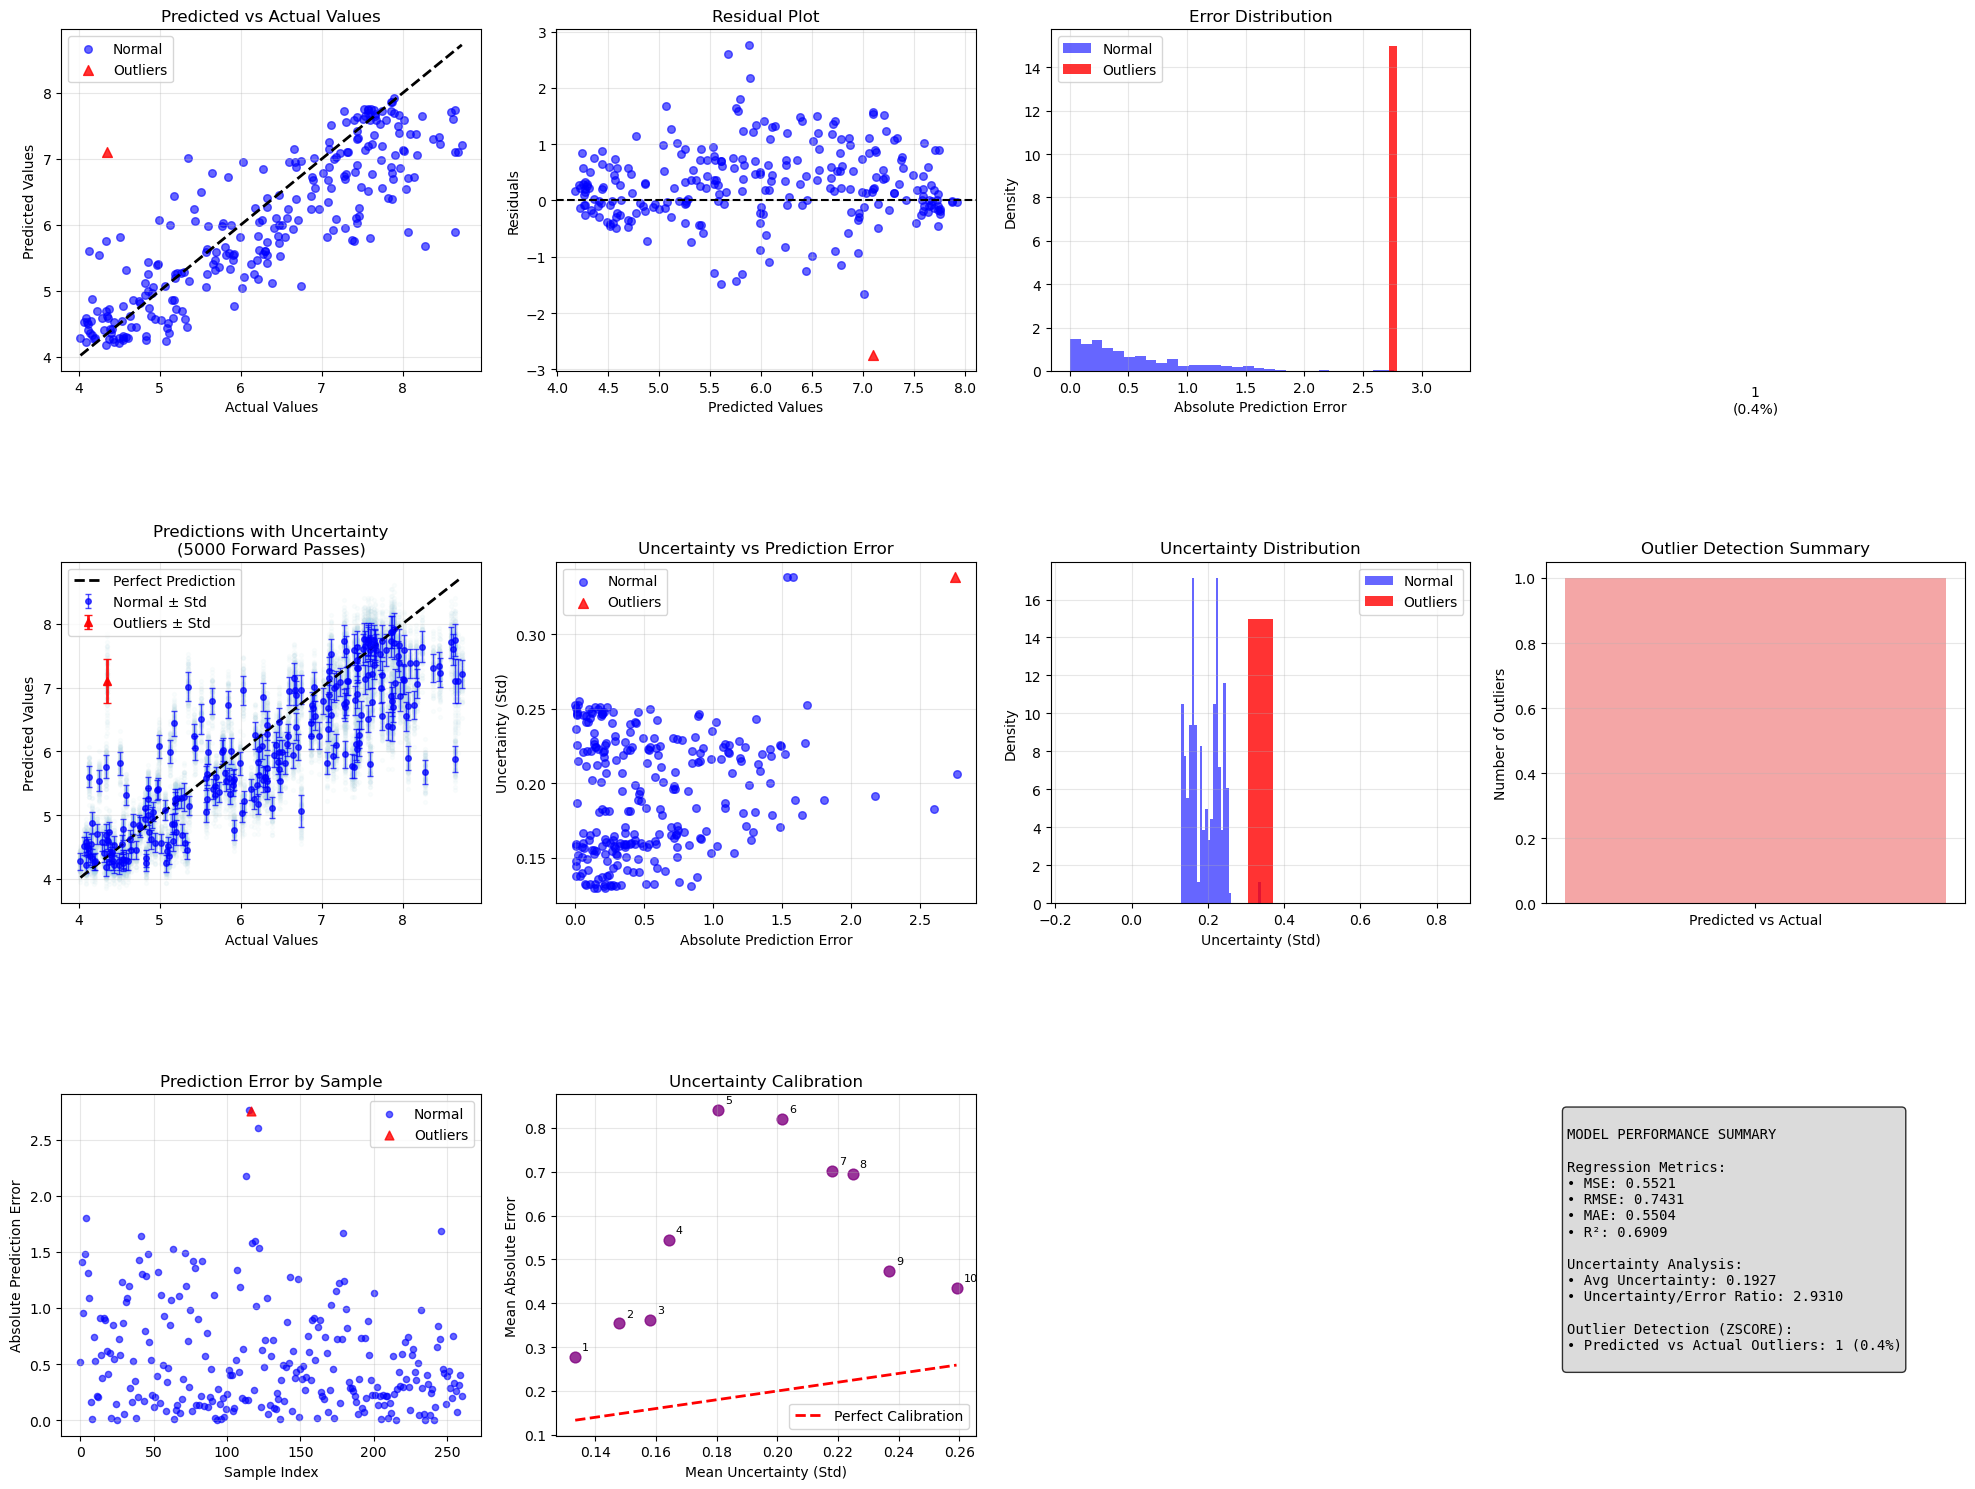

In [12]:
results = comprehensive_evaluation(model, X_test, y_test, n_samples=5000, 
                           outlier_method='zscore', outlier_threshold=4,
                           save_plots=True, output_dir='model_evaluation_plots')

In [14]:
from sklearn.decomposition import PCA

def plot_pca_with_outliers_and_background(X_test, outlier_mask, og_data_path, fp_kwargs, title="PCA with Outliers"):
    """
    Plot PCA with test set points, outliers highlighted, and training set as background.

    Parameters:
        X_test (ndarray): Test set features (n_samples, n_features)
        outlier_mask (ndarray): Boolean array marking outliers in test set
        og_data_path (str): Path to CSV with training set
        fp_kwargs (dict): Parameters for generate_fingerprints()
        title (str): Plot title
    """
    # Load and featurize original training set
    og_data = pd.read_csv(og_data_path)
    train_fps = []
    for smi in og_data['CXSMILES']:
        fp = generate_fingerprints(smi, **fp_kwargs)
        if fp is not None:
            train_fps.append(fp)
    X_train = np.array(train_fps)

    # Combine for PCA
    X_combined = np.vstack([X_train, X_test])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_combined)

    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # Separate transformed train/test sets
    n_train = X_train.shape[0]
    X_train_pca = X_pca[:n_train]
    X_test_pca = X_pca[n_train:]

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                c='grey', alpha=0.4, label='Training set')
    plt.scatter(X_test_pca[~outlier_mask, 0], X_test_pca[~outlier_mask, 1], 
                c='blue', alpha=0.7, label='Test set (normal)')
    plt.scatter(X_test_pca[outlier_mask, 0], X_test_pca[outlier_mask, 1], 
                c='red', marker='^', s=50, alpha=0.9, label='Test set (outliers)')

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_with_outliers_and_background.pdf', format='pdf', dpi=300, bbox_inches='tight')

[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerator
[10:23:58] DEPRECATION WARNING: please use MorganGenerat

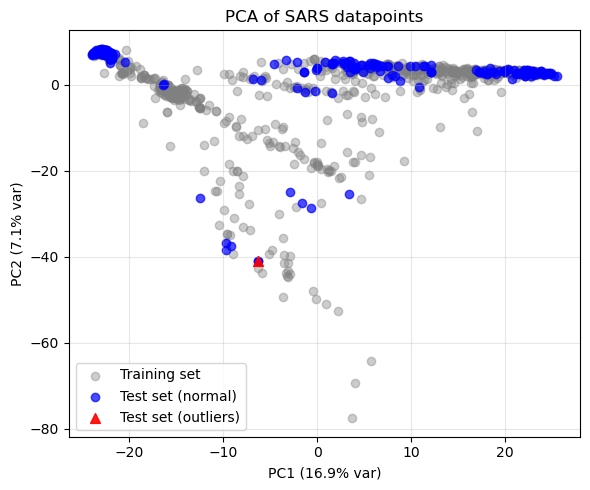

In [ ]:
plot_pca_with_outliers_and_background(
    X_test,
    results["outliers"],
    "PATH_TO_TRAINING_DATA",
    fp_config,
    title="PCA of SARS datapoints"
)